# Human Endometrial Cell Atlas (HECA): a step-by-step guide to mapping query endometrial datasets to the reference atlas.

In this notebook, we will use scArches model surgery ([paper](https://www.nature.com/articles/s41587-021-01001-7), [github](https://github.com/theislab/scarches)) to map single-cell RNA-seq data of human endometrium (i.e. the query dataset) to scRNA-seq data our integrated reference atlas of the endometrium - the HECA. This tutorial was adapted from the [fetal immune reference](https://github.com/Teichlab/Pan_fetal_immune/blob/master/tutorials/tutorial_query2reference_mapping.ipynb) and [scANVI](https://docs.scarches.org/en/latest/scanvi_surgery_pipeline.html) tutorials.

In this tutorial, the query dataset consists of three additional endometrial samples from [Huang et al, 2023](https://academic.oup.com/cei/article-abstract/212/3/285/7069119?redirectedFrom=fulltext). Data for these three samples were made publicly available after the main analysis for our publication was already carried out. Therefore, these samples were not included in the original reference model. However, it is important to note that because the reference model includes other samples (n = 10) from the same Huang et al. publication, the 3 samples presented here may map more closely to the reference atlas than entirely new samples. 


The scVI model in our paper was trained using a variable with dataset name as the batch covariate, and the variable with sample ID (genotype) as an additional categorical covariate. The current version of scArches (0.5.9) does not suport the inclusion of additional categorical covariates, therefore for the purposes of this tutorial we trained a new scANVI model using sample ID (genotype) as batch covariate, and our fine-grained cell type annotations as cell type labels (note that each genotype is present in only one dataset). While this may slighlty modify the appearance of the UMAP (orientation of the different cell clusters), it does not affect result interpretation. 

In [ ]:
# In this notebook, we will use the scarches package
# If you haven't installed scarches yet, run the following command to install version 0.5.9.
# this will ensure compatibility with the code in this notebooks

! pip install scarches==0.5.9

# Additionally, scarches may have dependencies on pandas, and we need to ensure it's installed.
# However, please note that we need a version lower than 2.0.0 for compatibility reasons.
# The following command will install the required version of pandas.

! pip install "pandas<2.0.0"

In [1]:
# We can now import our packages
import os
import warnings
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

import scvi

import pandas as pd

/home/jovyan/my-conda-envs/scarches/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/jovyan/my-conda-envs/scarches/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/jovyan/my-conda-envs/scarches/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [2]:
# set notebook parameters

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

## Load data

The data from HECA can be downloaded from [Reproductive Cell Atlas](https://www.reproductivecellatlas.org/endometrium_reference.html)

In [3]:
# Load the single-cell RNA-seq dataset downloaded from Reproductive Cell Atlas portal.
# Replace "/path/to/data.h5ad" with the file where HECA is stored
ref_adata = sc.read_h5ad("/path/to/data.h5ad")

In [4]:
# cellxgene object has normalized data in slot X
# bring back raw counts
ref_adata.X = ref_adata.layers["counts"]

In [5]:
# Subset to highly variable genes
ref_adata = ref_adata[:, ref_adata.var.highly_variable].copy()

Before mapping to the reference data, we need to run a few checks:
* scANVI uses raw counts as input, we need to check query_adata.X is raw counts
* the pretrained scANVI model uses gene names as variable names, we need to check that query_adata.var_names corresponds to gene names

In this tutorial, we are using samples GSM7277296, GSM7277297, GSM7277298 from Gene Expression Omnibus (accession code [GSE214411](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE214411)). The raw data was processed according to the Methods described in the HECA paper.

In [6]:
# Load the query single-cell RNA-seq data (with raw counts matrix)
# Replace "/path/to/Huang_counts.h5ad" with the actual file path of your query dataset.

# query_adata = sc.read_h5ad('/path/to/Huang_counts.h5ad')
query_adata = sc.read_h5ad('../data/Huang_counts.h5ad')

In [7]:
# We now check that the data is in the right format

def _verify_counts(adata):
    # The function checks if all elements in the first row of the gene expression matrix (adata.X) are integers.
    # If they are, it is likely that the data represents raw counts.

    return(all([not (i%1) for i in adata.X[0,:].toarray()[0]]))

if not _verify_counts(query_adata):
    raise ValueError('`target_adata.X` does not contain raw counts.')

# Additionally, we check if the gene names in the query dataset (query_adata.var_names) start with "ENS",
# which typically indicates Ensembl geneIDs. If all gene names follow this pattern, we raise a ValueError
# suggesting to convert them to gene symbols to match the names on our pretrained scVI model.

if query_adata.var_names.str.startswith("ENS").all():
    raise ValueError('`target_adata.var_names` are Ensembl geneIDs. Please convert to gene symbols')

## Create scANVI model and train on fully labelled HECA reference dataset

In [8]:
## Set up - set anndata batch and cell type variables
# the conditon_key variable represents the "batch" variable (that we want to correct for)
# in HECA, this corresponds to individual donors 
condition_key = 'genotype'

# here we indicated which column of adata.obs has information on cell annotations 
# cells in HECA were manually annotated as described in the main manuscript
cell_type_key = 'celltype'


In [9]:
## Train scANVI model from scVI model 
## This step does not need to be repeated if you are downloading scanvi model weights 
## and is included purely for reproducibility

# sca.models.SCVI.setup_anndata(ref_adata, batch_key=condition_key, labels_key=cell_type_key)

# vae = sca.models.SCVI(
#     ref_adata,
#     n_layers=2,
#     encode_covariates=True,
#     deeply_inject_covariates=False,
#     use_layer_norm="both",
#     use_batch_norm="none",
# )

# vae.train()

# scanvae = sca.models.SCANVI.from_scvi_model(vae, unlabeled_category = "Unknown")

# print("Labelled Indices: ", len(scanvae._labeled_indices))
# print("Unlabelled Indices: ", len(scanvae._unlabeled_indices))

# scanvae.train(max_epochs=20)

We are now ready to load the pre-trained model weights. The model weights can also be downloaded from the [Reproductive Cell Atlas](https://www.reproductivecellatlas.org/endometrium_reference.html). The downloaded object is stored as `.pt` PyTorch object. In order to ensure compatibility with scArches, the model should be stored as `model.pt` in a folder whose name matches the `ref_path` variable.

You can also retrain the model from scratch using the code above, but it faster to simply download the model weights! 

In [10]:
ref_path = "HECA_scanvi/"
scanvae = sca.models.SCANVI.load(ref_path, ref_adata)

INFO     File HECA_scanvi/model.pt already downloaded                                                              


## Perform surgery on reference model and train on query dataset without cell type labels

In this section, we will set up the query dataset (query_adata) for integration or transfer learning. The `sca.models.SCANVI.prepare_query_anndata` function will preprocess the query dataset and align its structure to be compatible with the reference dataset. In particular, the function will keep only the genes which are found in the reference dataset. In our case, 99.5% of the genes in the reference are found in the query dataset, however model performance is not expected to drop dramatically if not all the genes in the reference are found in the query.


In [11]:
sca.models.SCANVI.prepare_query_anndata(query_adata, scanvae)

# Since the query dataset might be unlabeled, we can mark them as unknown using scanvae.unlabeled_category_
query_adata.obs[cell_type_key] = scanvae.unlabeled_category_

INFO     Found 99.5% reference vars in query data.                                                                 


In [20]:
# we set up our surgery model by giving it our new query data
# and pointing it to the reference model 
model = sca.models.SCANVI.load_query_data(
    query_adata,
    ref_path,
    freeze_dropout = True,
)

model._unlabeled_indices = np.arange(query_adata.n_obs)
model._labeled_indices = []
print("Labelled Indices: ", len(model._labeled_indices))
print("Unlabelled Indices: ", len(model._unlabeled_indices))


INFO     File HECA_scanvi/model.pt already downloaded                                                              
Labelled Indices:  0
Unlabelled Indices:  21495


Here, we set the weight_decay to 0 to ensure that reference cell embeddings remain identical. We train the model for 100 epochs, however this can be increased/decreased if necessary.


In [13]:
# model.train(
#     max_epochs=100,
#     plan_kwargs=dict(weight_decay=0.0),
#     check_val_every_n_epoch=10,
# )

In [14]:
# Save model for future use
surgery_path = 'model_surgery'

In [15]:
# model.save(surgery_path, overwrite=True)

In [21]:
# code to reload the model after training:
model = scvi.model.SCANVI.load(surgery_path, query_adata)

INFO     File model_surgery/model.pt already downloaded                                                            


### Get latent representations and visualize

We have now trained a new variational autoencoder (`model`) which maps our input gene expression matrix to a lower dimension latent space. We can use scArches functions to create an `AnnData` object with the learned latent representation in the adata.X slot. We can then use `scanpy` functions to visualize this latent representation. 

In [22]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['celltype'] = query_adata.obs[cell_type_key].tolist()
query_latent.obs['genotype'] = query_adata.obs[condition_key].tolist()

In [23]:
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent, min_dist=0.4)


/home/jovyan/my-conda-envs/scarches/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jovyan/my-conda-envs/scarches/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jovyan/my-conda-envs/scarches/lib/python3.9/site-packages/umap/d

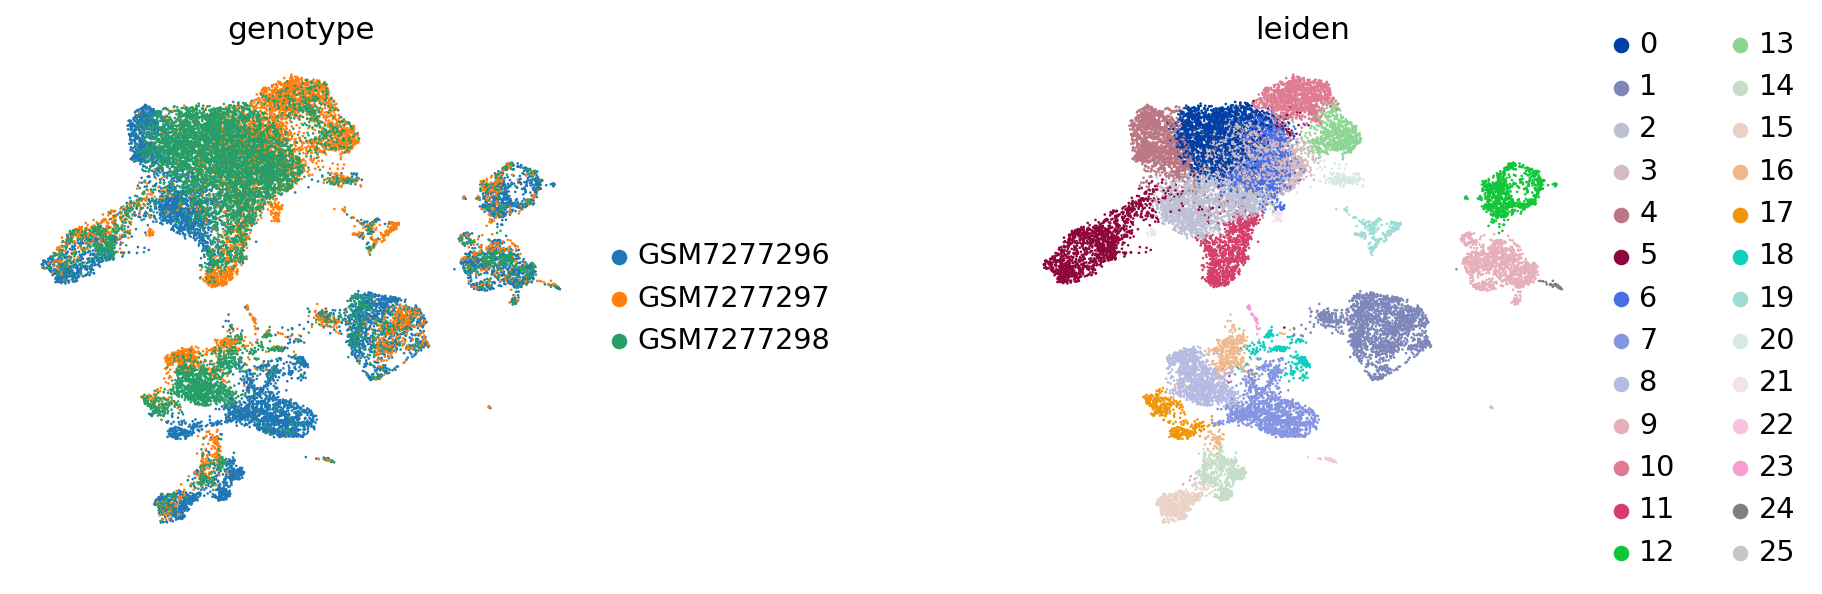

In [24]:
sc.pl.umap(
    query_latent,
    color=["genotype", "leiden"],
    frameon=False,
    wspace=0.6,
)

### Marker gene visualization

We cluster the cells using leiden clustering, then visualize the expression of marker genes in each cluster to assign them to a high level lineage

In [25]:
## add leiden clusters to query anndata object with raw counts 
query_adata.obs["leiden"] = query_latent.obs["leiden"].tolist()

In [26]:
## store counts in raw layes 
query_adata.layers['counts']=query_adata.X.copy() 

In [27]:
## normalize and log transform
sc.pp.normalize_total(query_adata, target_sum=1e4)
sc.pp.log1p(query_adata)

`sc.pl.dotplot()` returns an error if we try to plot genes that are not included in our anndata object so we create a helper function that will automatically filter our markers and only return genes which are present in our anndata object of interest (`query_adata` by default)

In [28]:

def filter_genes(marker_dict, adata = query_adata):
    """
    Filter a list of marker genes to only keep those present in adata varnames
    """
    filtered_dict = {}
    
    gene_names = adata.var_names.tolist()
    
    for key, value in marker_dict.items():
        filtered_genes = value.intersection(gene_names)
        if len(filtered_genes) > 0:
            filtered_dict[key] = filtered_genes
        else:
            print("No gene founds for", key)
        
    return filtered_dict

In [29]:
# markers for main endometrial cell lineages as used in the HECA

lineage_markers = {"Endothelial" : {"CDH5", "VWF"},
                  "Epithelial" : {"EPCAM", "PAX8"},
                  "Immune" : {"PTPRC", "CD3D", "NKG7", "CSF1R"},
                  "Mensechymal" : {"PCOLCE", "DCN", "COL1A1"}}

In [30]:
lineage_markers = filter_genes(lineage_markers)

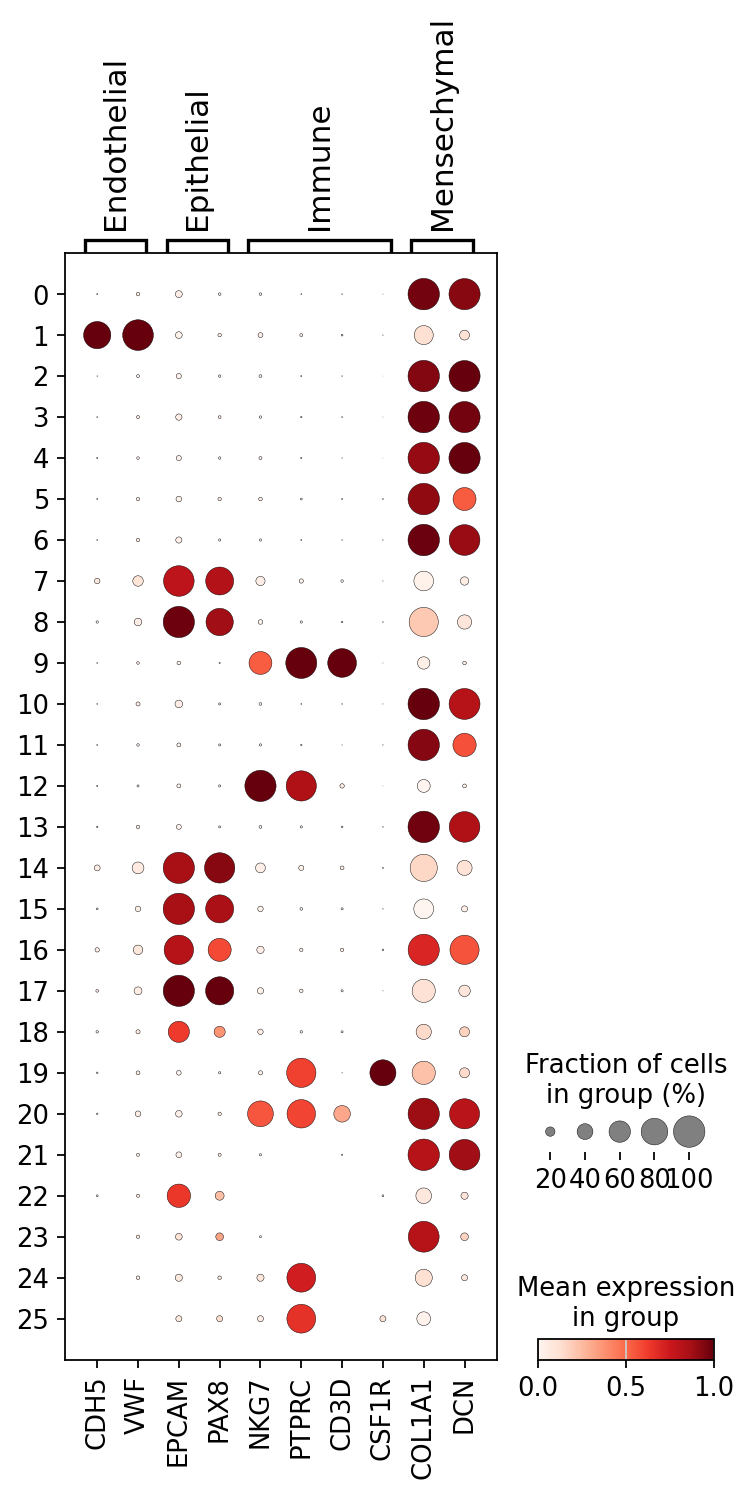

In [31]:
# visualise main endometrial cell lineage markers per cluster in the query dataset
sc.pl.dotplot(query_adata, lineage_markers, groupby = "leiden", standard_scale = "var" )

In [32]:
# assign cell lineages based on marker gene expression

cluster_lineage = {"Endothelial" : ["1"],
                  "Epithelial" : ["7", "8", "14", "15", "16", "17", "18", "22"],
                  "Immune" : ["9", "12", "19", "24", "25"],
                  "Mesenchymal" : ["0", "2", "3", "4", "5", "6", "10", "11", "13", "20", "21", "23"], 
                  "Doublets" : ["20"]}

In [33]:
query_latent.obs["lineage"] = query_latent.obs["leiden"].map({value: category for category, values in cluster_lineage.items() for value in values})

In [34]:
query_adata.obs["lineage"] = query_latent.obs["lineage"].tolist()

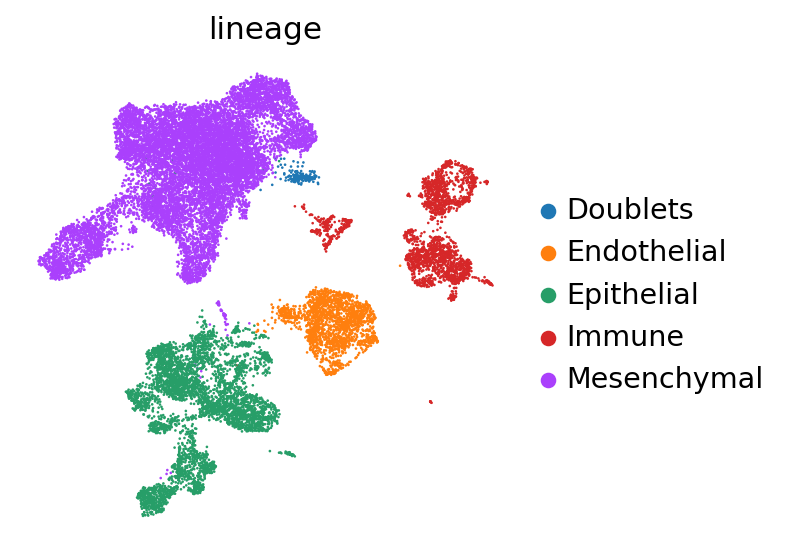

In [35]:
sc.pl.umap(
    query_latent,
    color="lineage",
    frameon=False,
    wspace=0.6,
)

## Visualize HECA and query dataset in shared latent space

We can use our new model to build a new anndata object that has the learned latent representation for both HECA and our query samples. This shared representation is the power of scArches and can be used to support downstream analysis. 

In [36]:
# Harmonize metadata columns before merging
query_adata.obs["dataset"] = "Huang_new" 
query_adata.obs["celltype"] = "Unknown"

# match the numbering and formating of Fig 1 in the paper
query_adata.obs["Symbol"] = "37"
query_adata.obs["label_long"] = "37 | Huang new samples"  

We normalized the data in slot query_adata.X in order to do marker visualization above, however scVI models need raw counts as input
so we get the counts which we stored in query_adata.layers['counts'] and put them back in adata.X.

In [37]:
query_adata.X = query_adata.layers['counts']

In order to visualize the query and reference datasets in the same latent space, we create a merged anndata object with both query and reference data and push it through the model using `model.get_latent_representation()`

We then create a new anndata object with this latent representation in slot X.

In [38]:
adata_full = ref_adata.concatenate(query_adata)
full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))

# add back our variables of interest in full_latent.obs
full_latent.obs['celltype'] = adata_full.obs[cell_type_key].tolist()
full_latent.obs['genotype'] = adata_full.obs[condition_key].tolist()
full_latent.obs["dataset"] = adata_full.obs["dataset"].tolist()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [39]:
# add colors for plotting
# here we assign a new singe color (dark grey) for the query dataset
full_latent.obs['label_long'] = adata_full.obs['label_long'].tolist()
full_latent.uns['label_long_colors'] = ref_adata.uns['label_long_colors'].tolist() + ["#3D3D3D"]
full_latent.obs['Symbol'] = adata_full.obs['Symbol'].tolist()

In [40]:
full_latent.uns['Symbol_colors'] = ref_adata.uns['Symbol_colors'].tolist() + ["#3D3D3D"]

In [ ]:
# We comptue the kNN graph and UMAP for 2D visualization of our scANVI embeddings
sc.pp.neighbors(full_latent)
sc.tl.umap(full_latent, min_dist = 0.4)

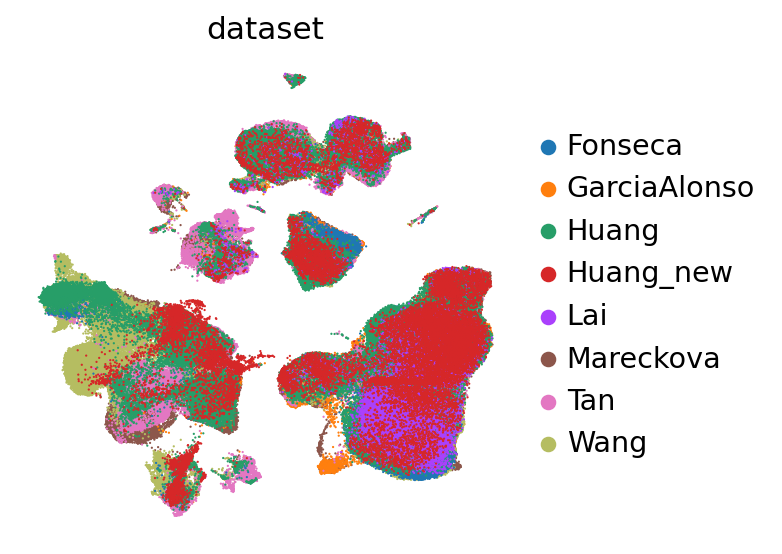

In [47]:
sc.pl.umap(full_latent,
           color=['dataset'],
           frameon=False,
           wspace=0.6, size = 4)

In [ ]:
# Create a new variable that will highlight the query samples 
# and grey out the reference cells
full_latent.obs["huang_viz"] = np.where(full_latent.obs["dataset"] == "Huang_new", 
                                        full_latent.obs["dataset"], 
                                        np.nan)

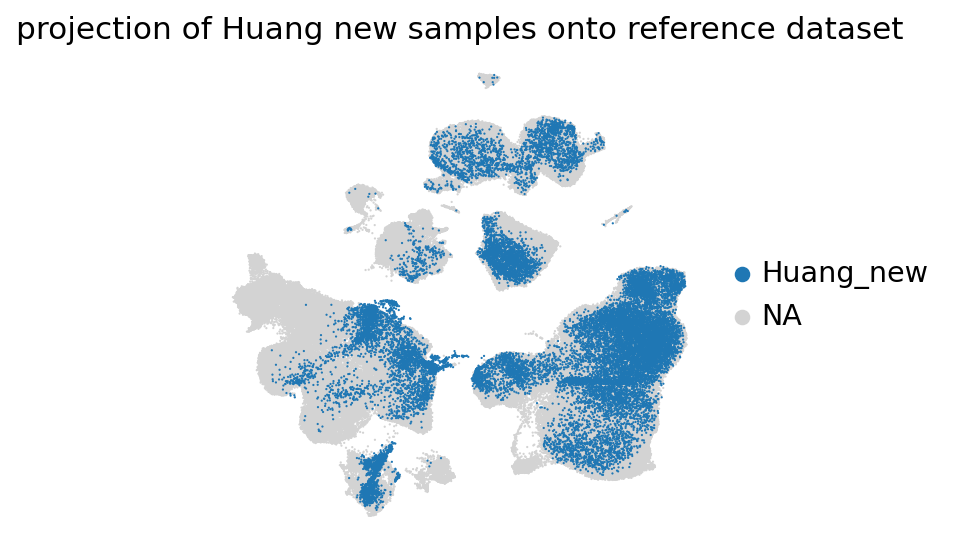

In [48]:
sc.pl.umap(full_latent,
           color=['huang_viz'],
           frameon=False,
           wspace=0.6, size = 4, 
           title="projection of Huang new samples onto reference dataset")

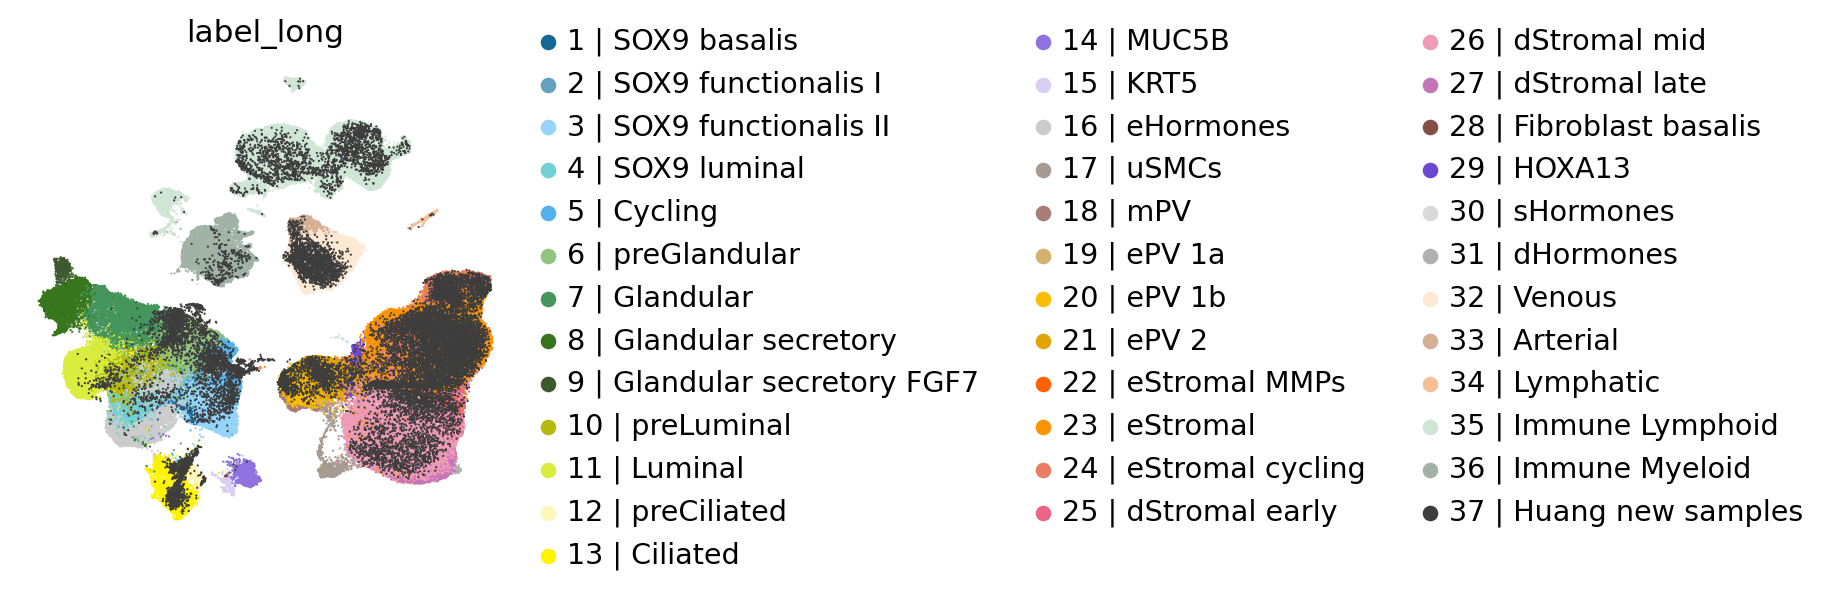

In [49]:
sc.pl.umap(full_latent,
           color=['label_long'],
           frameon=False,
           wspace=0.6, size = 4)

In [52]:
# We are now going to visualize our query dataset labels in the shared latent space
# we need to do same data wrangling to add the right labels to the full_latent object

# when we create an anndata object from scratch, we lose the indices for the observations 
# soin order to merge with the query dataset, we need to add back these indices
full_latent.obs.index = adata_full.obs.index

# back in the query_latent object, 
# we create a new variable of the form Lineage_clusternumber
query_latent.obs["lineage_cl"] = query_latent.obs["lineage"].astype(str) + "_" + query_latent.obs["leiden"].astype(str)

# as above, add the original cell indices to the anndata object with the latent representation
query_latent.obs.index = query_adata.obs.index.to_list()

# in the process of making obs names unqiue in the joint anndata object, 
# "-1" was added to the indices
# so we create a new dummy index in the same format as the full dataset indices to be able to do the join
query_latent.obs["index_u"] = query_latent.obs.index + "-1"

# finally, join the datasets 
# the new object will have our manual labels as obs colunm
# with NAs for the reference
full_latent.obs = full_latent.obs.join(query_latent.obs.set_index("index_u")[["lineage_cl"]])

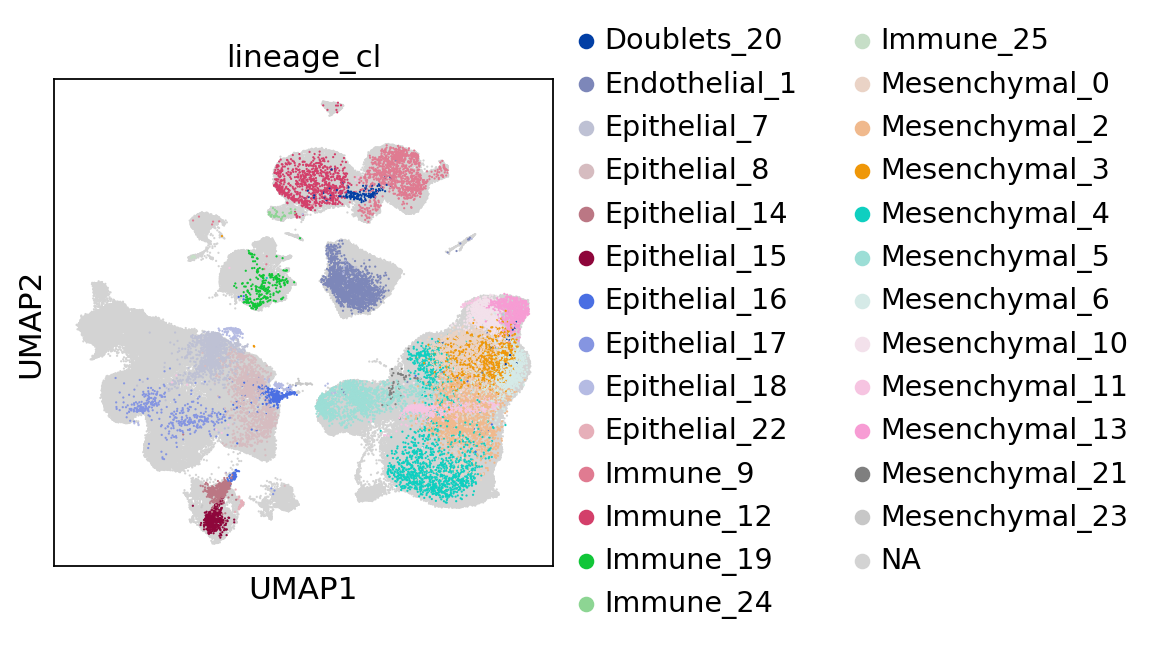

In [53]:
sc.pl.umap(full_latent, 
          color = "lineage_cl", 
          size = 4)

## Compare expression of marker genes

We can explore the similarity of marker gene expression between annotated HECA cells and projected query cells. 

In [54]:
def filter_by_lineage(adata, lineage):
    """
    Helper function for visualizing cells by lineage:
    
    1. filter full dataset to only keep cells belonging to `lineage`
    2. reorder "ct_merged" variable for plotting
    
    """
    
    
    adata_filter = adata_full[(adata_full.obs["lineage_merged"] == lineage), :]
    
    # Reorder for plotting 
    # the query dataset cells are Lineage_cluster
    # group all the query cells together
    ct_ordered = adata_filter.obs["ct_merged"].unique().tolist()
    ct_ordered = sorted([i for i in ct_ordered if lineage + "_" in i]) + sorted([i for i in ct_ordered if lineage + "_" not in i])

    adata_filter.obs["ct_merged"] = adata_filter.obs["ct_merged"].astype("category").cat.reorder_categories(ct_ordered)
    
    return adata_filter


In [55]:
adata_full.obs = adata_full.obs.join(query_latent.obs.set_index("index_u").rename(columns = {"lineage" : "manual_lineage"})[["manual_lineage", "lineage_cl"]])

adata_full.obs["lineage_merged"] = np.where(adata_full.obs["dataset"] == "Huang_new", 
                                            adata_full.obs["manual_lineage"], 
                                            adata_full.obs["lineage"])

adata_full.obs["ct_merged"] = np.where(adata_full.obs["dataset"] == "Huang_new", 
                                            adata_full.obs["lineage_cl"], 
                                            adata_full.obs["celltype"])


In [56]:
# Use cell type markers from HECA 

epithelial_markers = {
    'Epithelial':{'EPCAM','PAX8'},
    'Glandular group':{'FOXA2'},
    'SOX9-MMP7':{'SOX9','MMP7'},
    'SOX9 basalis (CDH2+)':{'KLK11', 'AXIN2', 'ALDH1A1','TRH','CDH2'}, 
    'SOX9 functionalis I (CDH2+)':{'SLC7A11', 'DKK1', 'PHLDA1'}, 
    'SOX9 functionalis II':{'IHH','KMO','EMID1'}, 
    'preGlandular':{'SUFU', 'CBR3', 'OPRK1','HPRT1'}, 
    'Glandular': {'SCGB2A2', 'S100P','ABCG1'}, 
    'Glandular secretory': {'DPP4', 'PAEP','GPX3'}, 
    'Glandular secretory (FGF7+)': {'FGF7', 'FXYD2', 'PTPRR'},
    'SOX9 luminal (LGR5+)':{'IL32', 'WNT7A', 'TNF','MMP7','LGR5'},
    'preLuminal':{'SULT1E1','VTCN1','CLDN22'},
    'Luminal':{'LEFTY1', 'PTGS1', 'LGR5', 'IL6'},
    'preCiliated':{'MUC12', 'CDC20B', 'CCNO'},
    'Ciliated': {'PIFO', 'FOXJ1', 'TP73'},
    'MUC5B':{'MUC5B', 'TFF3', 'SAA1','BPIFB1'},
    'KRT5':{'KRT5', 'TP63', 'SNCG'},
    'Steroid receptors':{'PGR', 'ESR1','AR'},
}

In [57]:
epithelial_markers = filter_genes(epithelial_markers, adata_full)

In [58]:
epithelial_full = filter_by_lineage(adata_full, "Epithelial")

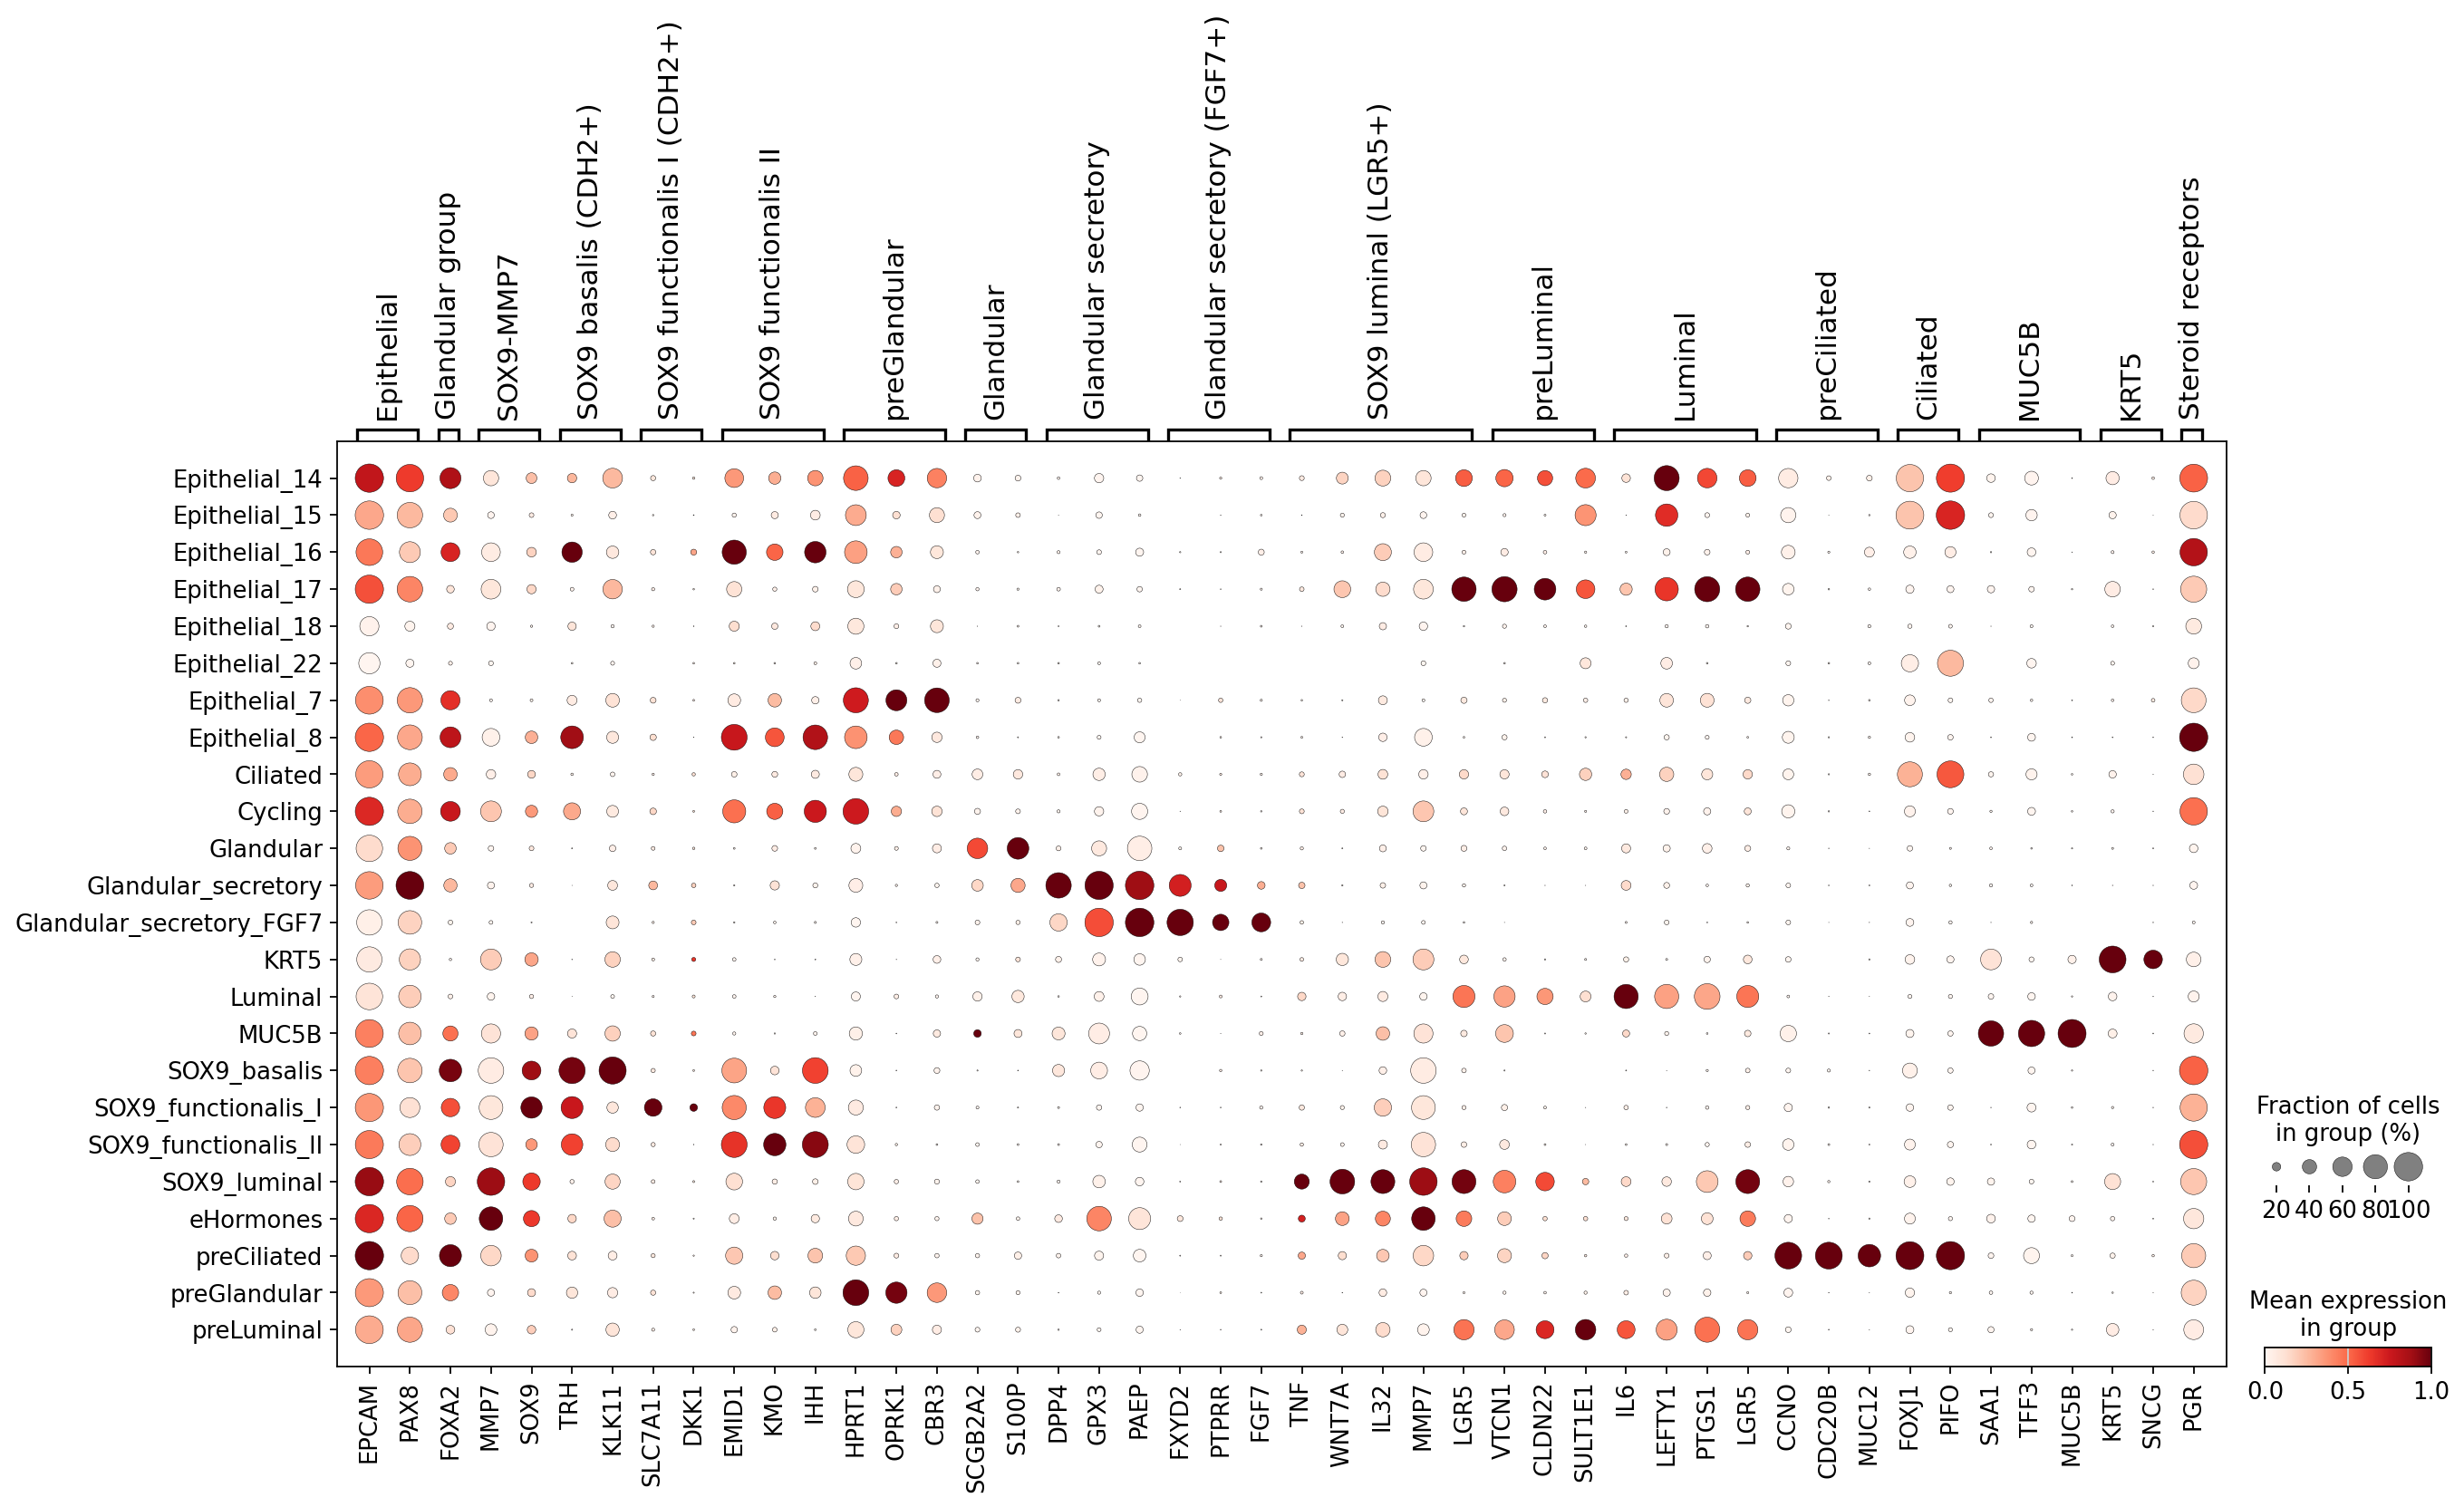

In [59]:
### Epithelial

sc.pl.dotplot(
    epithelial_full, 
    epithelial_markers, 
    groupby = "ct_merged", 
    standard_scale = "var"
)             

In [60]:
# Use mesenchymal cell type markers from HECA 

mesen_markers = {
    'Mesenchymal_general':{'PCOLCE','DCN'},
    'uSMCs':{'ACTG2', 'DES','PTGER3'}, 
    'Perivascular_general':{'RGS5'},
    'ePV-1a (STEAP4+)':{'STEAP4', 'SSTR2', 'SMTNL2'}, 
    'ePV-2b (STC2+)':{'SLC38A11','MYOM2','STC2'}, 
    'ePV-2 (MMP11+)':{'MMP11', 'TDO2', 'CYGB'},
    'Stromal_general':{'PDGFRA'},
    'Stromal_progenitor':{'SUSD2','MCAM','PDGFRB'},
    'eStromal':{'MMP11', 'CRABP2','TUNAR', 'FOXL2', 'TGFBI', 'F13A1'},
    'eStromal MMPs':{'INHBA', 'MMP10','MMP3', 'MMP1', 'COL8A1'}, 
    'dStromal early':{'CILP', 'CALB2', 'PCSK6', 'TPPP3','PLCL1'},
    'dStromal mid':{'SCARA5', 'CXCL13', 'GABRA2', 'TLR4'},
    'dStromal late':{'SMAD7','CXCL8', 'CXCL2','TRIB1', 'LEFTY2'},
    'Fibroblast basalis': {'C7', 'PTGIS'}, 
    'Steroid receptors':{'PGR', 'ESR1','AR'} 
}

In [61]:
mesen_markers = filter_genes(mesen_markers, adata_full)

No gene founds for Stromal_general


In [62]:
mesen_full = filter_by_lineage(adata_full, "Mesenchymal")

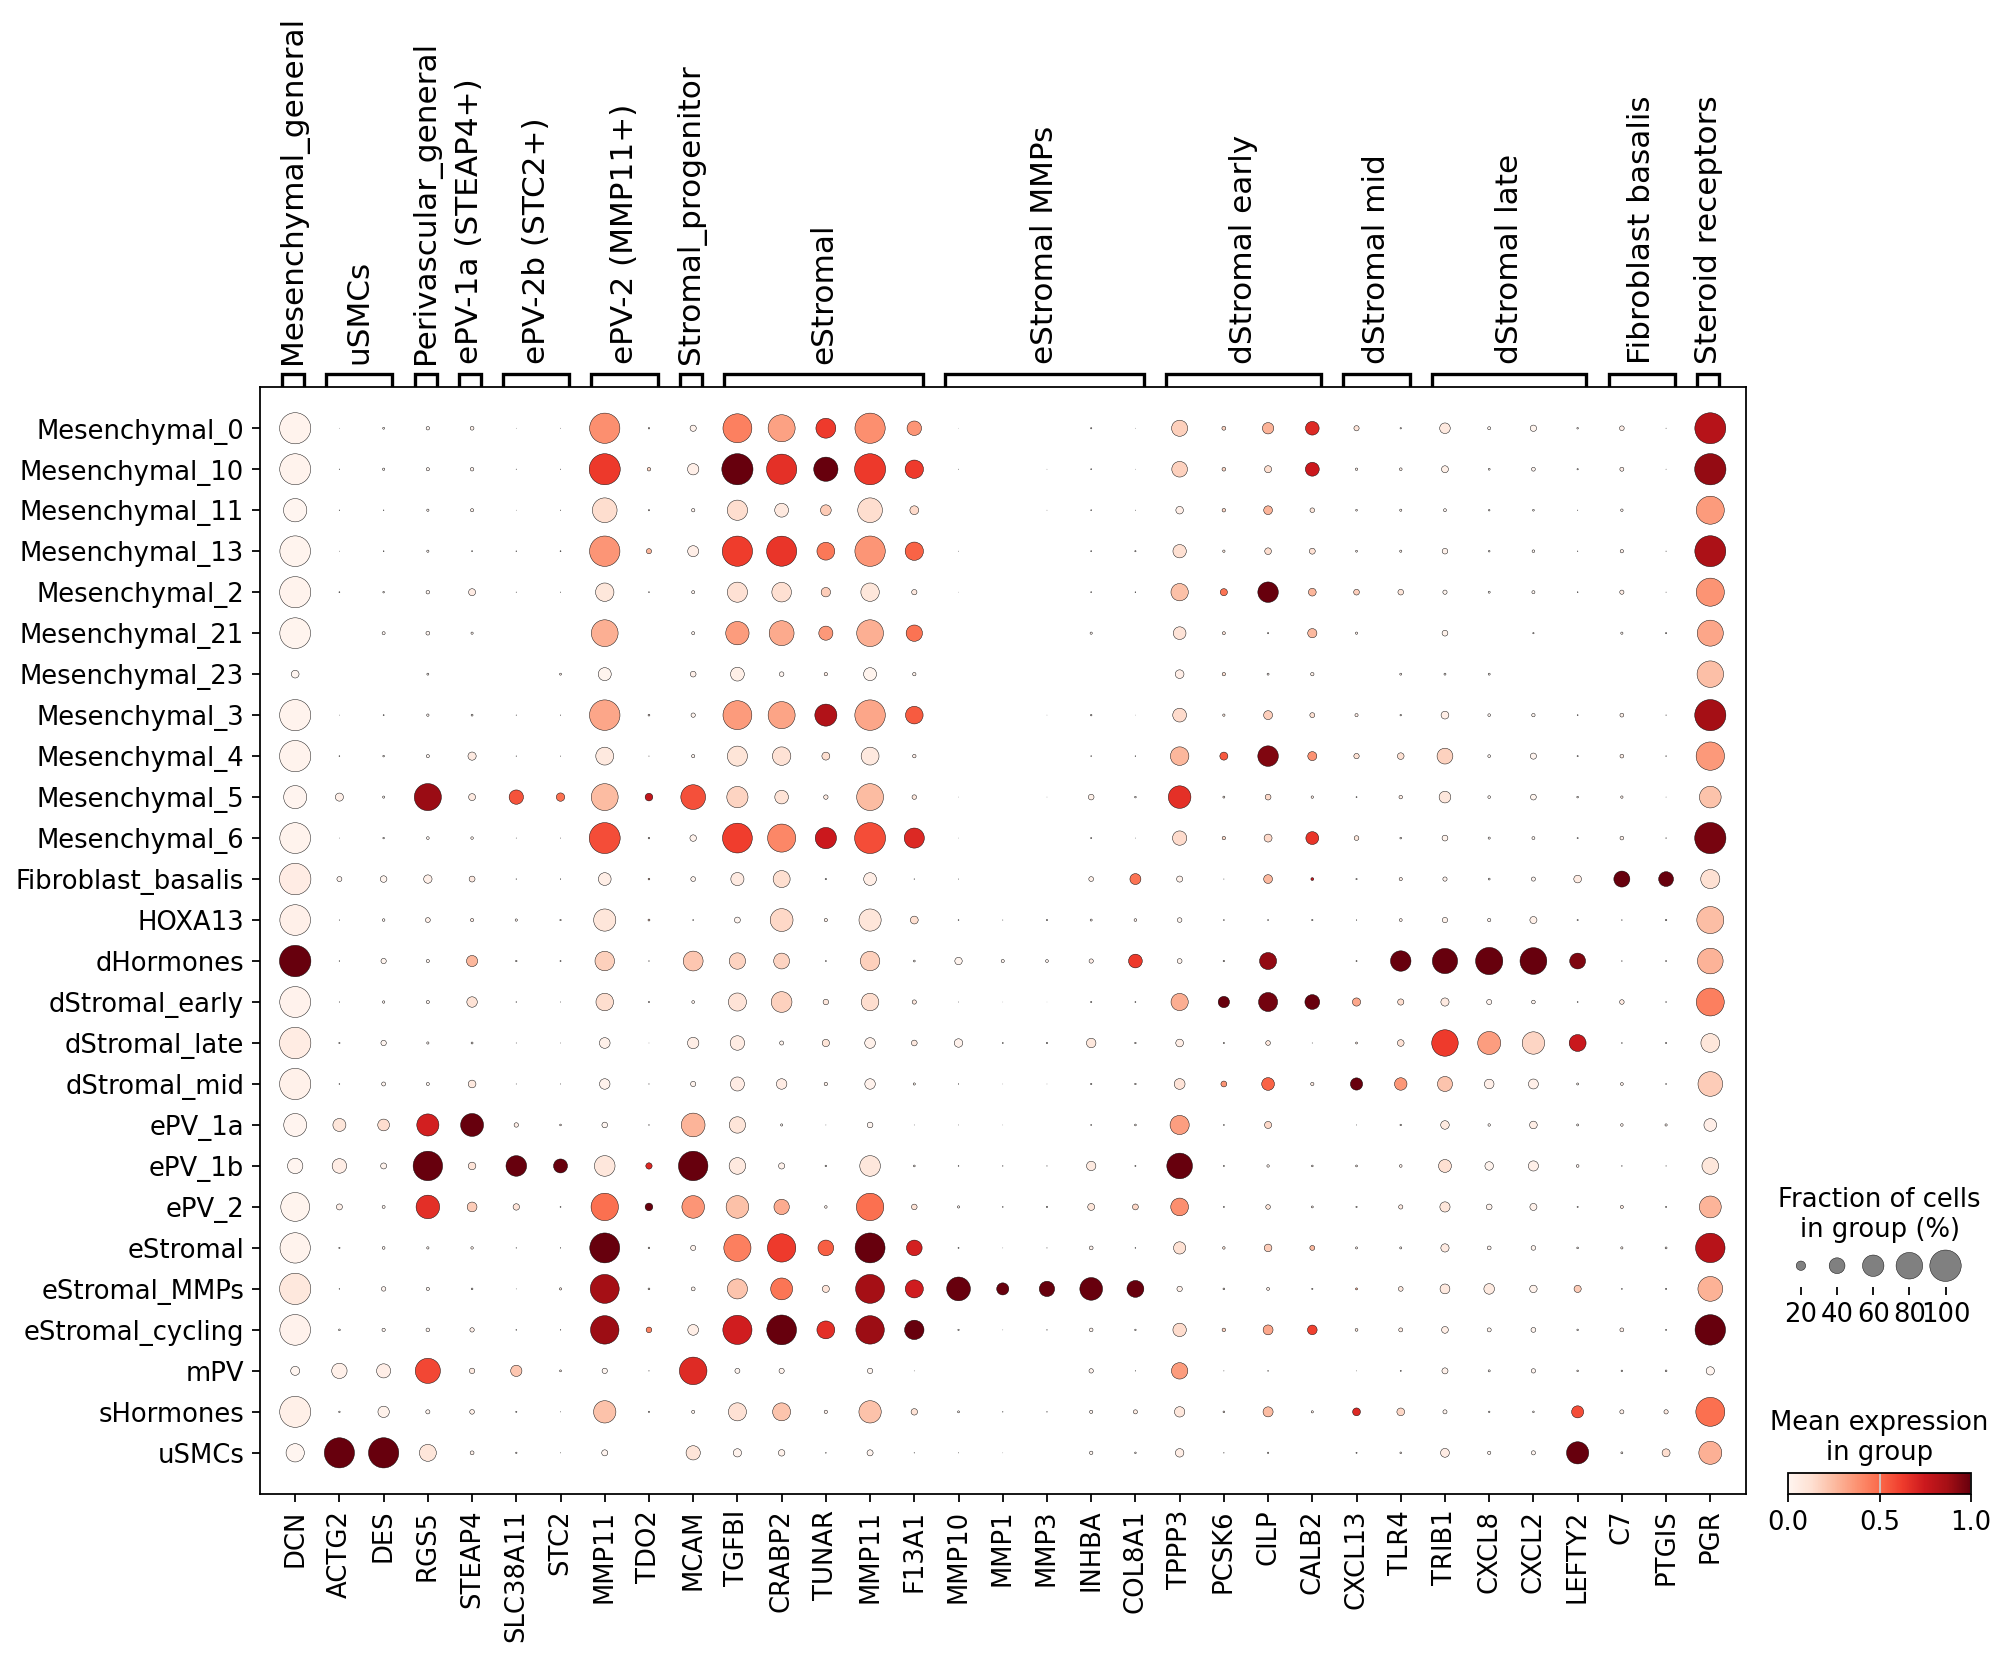

In [63]:
sc.pl.dotplot(mesen_full, 
              mesen_markers, 
              groupby = "ct_merged", 
              standard_scale = "var")

In [64]:
# Use endothelial markers from HECA 

endothelial_markers = {
    'Endothelial_general':{'CDH5','VWF'},
    'Venous (ACKR1+)': {'ACKR1','TNC', 'CCL14'},
    'Arterial (SEMA3G+)':{'SEMA3G', 'GJA5','CXCR4'},
    'Lymphatic':{'RELN', 'PROX1', 'CCL21'},
}

In [65]:
endothelial_markers = filter_genes(endothelial_markers, adata_full)

In [66]:
endo_full = filter_by_lineage(adata_full, "Endothelial")

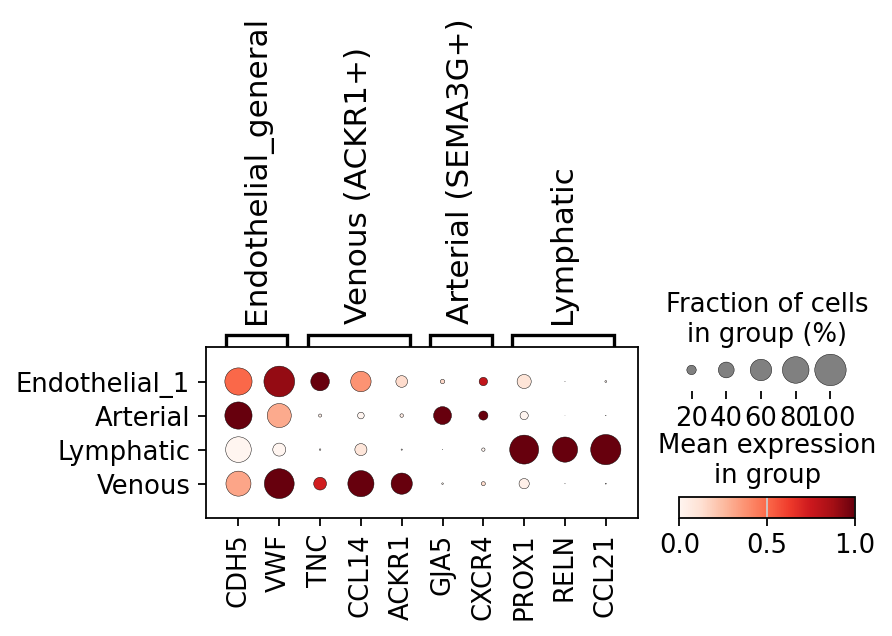

In [67]:
sc.pl.dotplot(endo_full, 
              endothelial_markers, 
              groupby = "ct_merged", 
              standard_scale = "var")

In [68]:
# Use immune markers from HECA 

immune_markers = {
    'Immune': {'PTPRC'},
    'Lymphoid': {'CD3D', 'NKG7', 'CD69'},
    'Myeloid': {'CSF1R', 'CD14'},
    'B-cell': {'CD19',  'MS4A1', 'CD79B', 'IL6', 'IGHM'},  
    'Plasma B-cell': {'SDC1', 'CD27'}, 
    'T-cell': {'CD3D', 'CD3G'},
    'CD4 T-cell': {'CD4'},
    'CD8 T-cell': {'CD8A', 'CCL5', 'CD28'},
    'T-regs': {'FOXP3', 'IL2RA'},
    'uNK cell': {'ITGA1', 'CD9'}, 
    'uNK1': {'GZMA', 'ENTPD1', 'CYP26A1', 'B4GALNT1'},
    'uNK2': {'CD7', 'ANXA1', 'ITGB2'},
    'uNK3': {'CD160', 'KLRB1',  'GZMM', 'GZMB', 'GNLY'},
    'ILC3': {'CXCR4', 'SPINK2'},
    'Myeloid': {'CSF1R', 'CD14'},
    'Dendritic cell': {'CD1C', 'FOXJ2', 'ID2'}, 
    'cDC1': {'IRF8', 'BATF3'},
    'cDC2': {'CD1C'},   
    'Macropgage (all)': {'CD14', 'CD68', 'CSF1R', 'FCGR3A'},
    'uM1': {'EREG', 'IL1B'},
    'uM2': {'CD14', 'FOLR2', 'SELENOP', 'HMOX1'},
    'Monocytes': {'S100A12', 'S100A9'},
    'Mast cell': {'CPA3', 'KIT', 'CSF1'},
    'pDC': {'IL3RA', 'TCF4'},
    'RBC':{'HBB'},
    'Steroid receptors':{'PGR', 'ESR1'}
}

In [69]:
immune_markers = filter_genes(immune_markers)

No gene founds for CD4 T-cell


In [70]:
immune_full = filter_by_lineage(adata_full, "Immune")

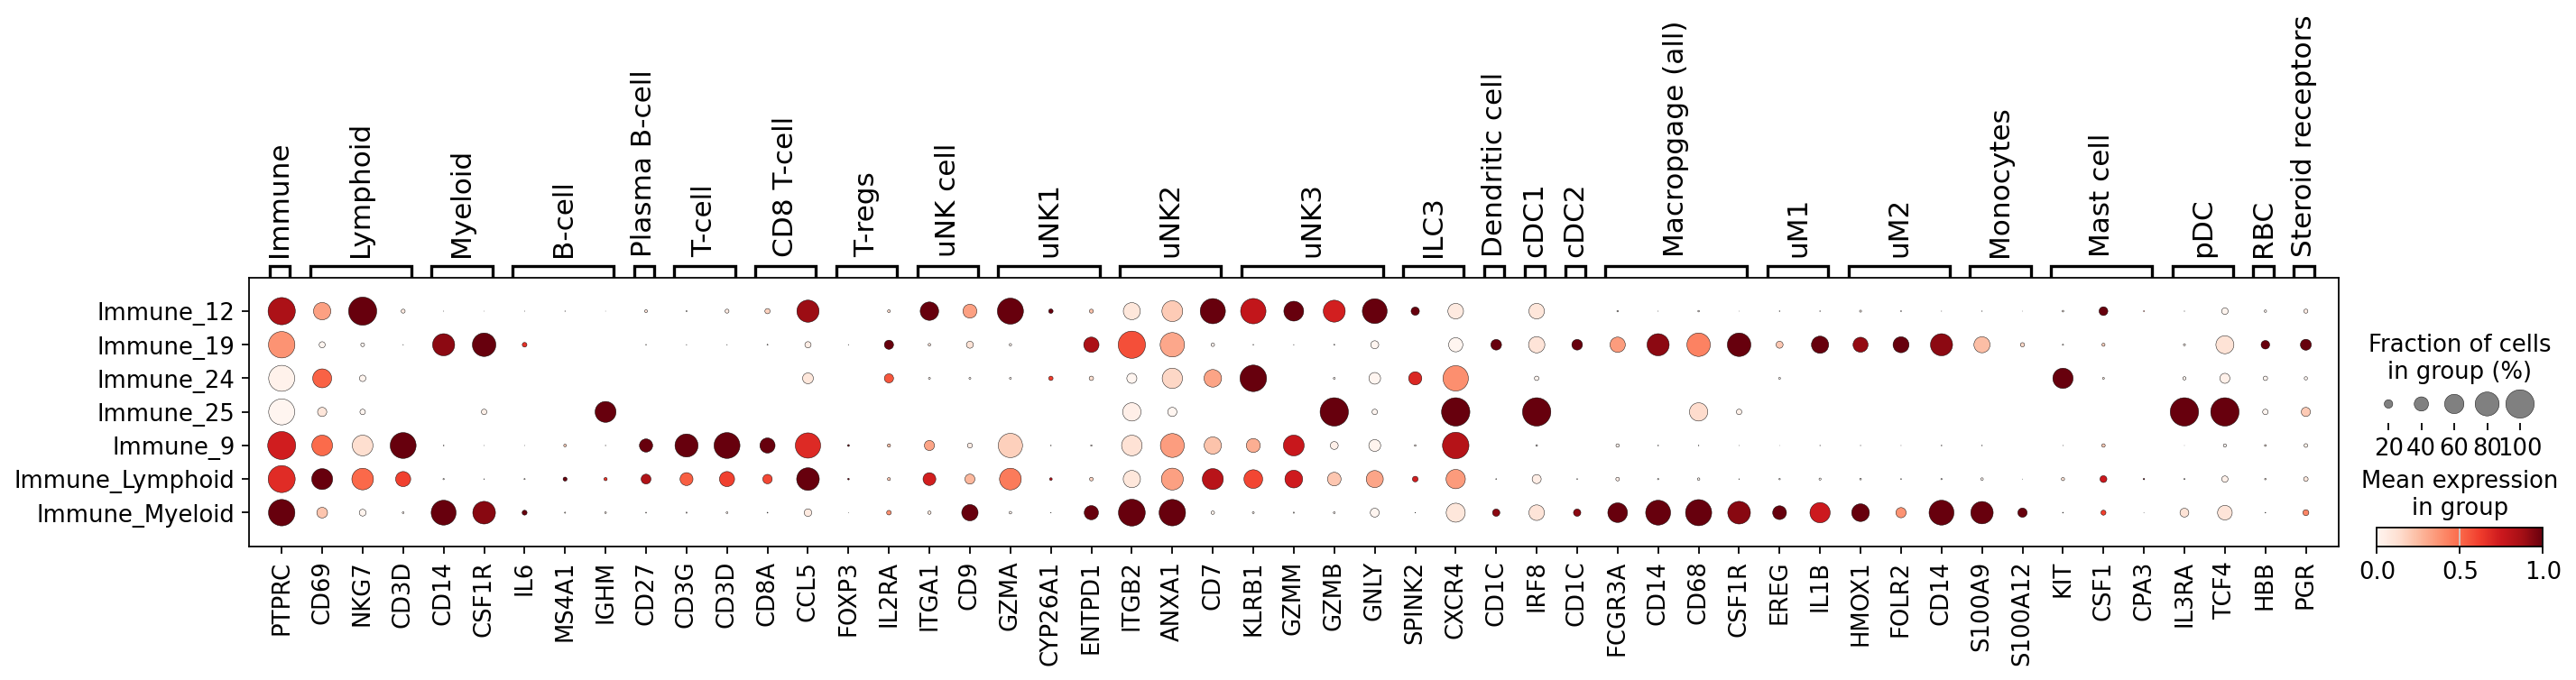

In [71]:
sc.pl.dotplot(immune_full, 
             immune_markers, 
             groupby = "ct_merged", 
             standard_scale = "var")

## A note on label transfer 

scANVI supports label transfer from reference to query dataset. It automatically learns a cell type classifier based on the scANVI embeddings. You can check the accuracy of the classifier on the predicted classifier  using the following code:

In [72]:
reference_latent = sc.AnnData(X = scanvae.get_latent_representation(),
                              obs = ref_adata.obs)
reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.celltype)))

Acc: 0.7563750490388388


However, the scANVI classifier does not perform as well for a high number of fine-grained labels ([Xu 2021](https://www.embopress.org/doi/full/10.15252/msb.20209620), scANVI [documentation](https://docs.scvi-tools.org/en/stable/user_guide/models/scanvi.html)) as used in our dataset. Therefore we recommend using alternative strategies for label transfer, for example support vector machine classifier trained on HECA or manual annotation. Example code for label transfer using SVM is provided [here](https://github.com/ventolab/HGDA/blob/main/mouse_scRNAseq/mouse_human_comparison/LabelTransfer_SupervisedLearning.py). This script can then be used to transfer labels from HECA using the following commands: